In [1]:
import gym 
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU 
import torch.nn.functional as F
from torch.autograd import Variable

This notebook use a off-policy Actor Critic Algorithm 

Key Algorithm:

See this [blog](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#off-policy-policy-gradient).

In [28]:
class Actor(torch.nn.Module):
    def __init__(self, buffer_size = 100):
        super(Actor,self).__init__()
        self.fc1 = Linear(4, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 2)
        self.fc4 = Linear(128, 1)
        self.buffer = []
        self.buffer_size = buffer_size
        self.A_Loss = []
        self.C_Loss = []
        self.steps = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action = F.log_softmax(self.fc3(x), dim=-1)
        V = F.relu(self.fc4(x))
        return action, V
    
    def buffer_in(self, obs, action,I, p, done):
        self.buffer.append((obs, action, I, p, done))
        if len(self.buffer) >= self.buffer_size:
            self.buffer.pop(0)
        if done:
            self.learn()
            
    def evaluate(self):
        env = gym.make('CartPole-v0')
        obs = env.reset()
        for episode in range(100):
            for step in range(200):
                #-----lines below are line-corresponding to the original algorithm----
                obs = np.reshape(obs, [1,-1])
                input_actor = Variable(torch.from_numpy(obs).float()).to(device)
                action_probability, _ = actor(input_actor)
                p = np.exp(action_probability[0].detach().cpu())
                action = np.random.choice(2, p=p.numpy())
                obs, reward, done, info = env.step(action)
                if done:
                    self.steps.append(step)
                    print(f'Evaluating: episode {episode}, step {step}', end='\r')
                    obs = env.reset()
                    break
    
    def learn(self):
        for t,  memory in enumerate(self.buffer):
            obs, action, I, p, done = memory
            obs = np.reshape(obs, [1,-1])
            input_actor = Variable(torch.from_numpy(obs).float()).to(device)
            action_probability, V = actor(input_actor)
            if t < len(self.buffer)-1:
                next_obs,_,_,_,_= self.buffer[t+1]              
                next_obs = np.reshape(obs, [1,-1])
                input_actor = Variable(torch.from_numpy(next_obs).float()).to(device)
                _, next_V = actor(input_actor)
                if not done:
                    delta = gamma*next_V.detach() + 1 - V 
                else:
                    delta = 1 - V 
                log_prob_c = action_probability[0][action]
                p_c = torch.exp(log_prob_c)
                rho = p_c/(0.75*p+0.25/2)
                Actor_Loss = - rho *log_prob_c* delta.detach()*I
                self.A_Loss.append(Actor_Loss)
                Critic_Loss = -alpha_c*delta.detach()*V
                self.C_Loss.append(Critic_Loss)
                loss = Actor_Loss + Critic_Loss
                actor.zero_grad()
                loss.backward()
                optimizer_actor.step()

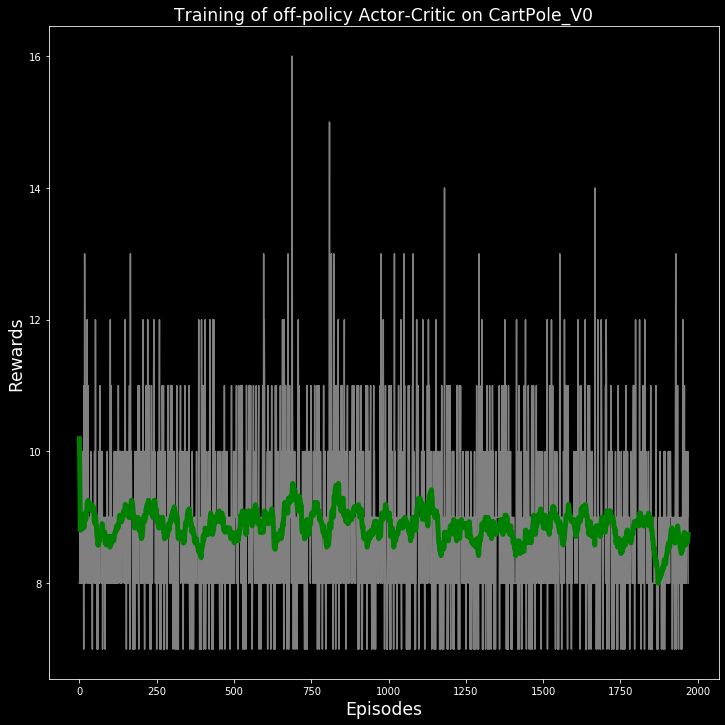

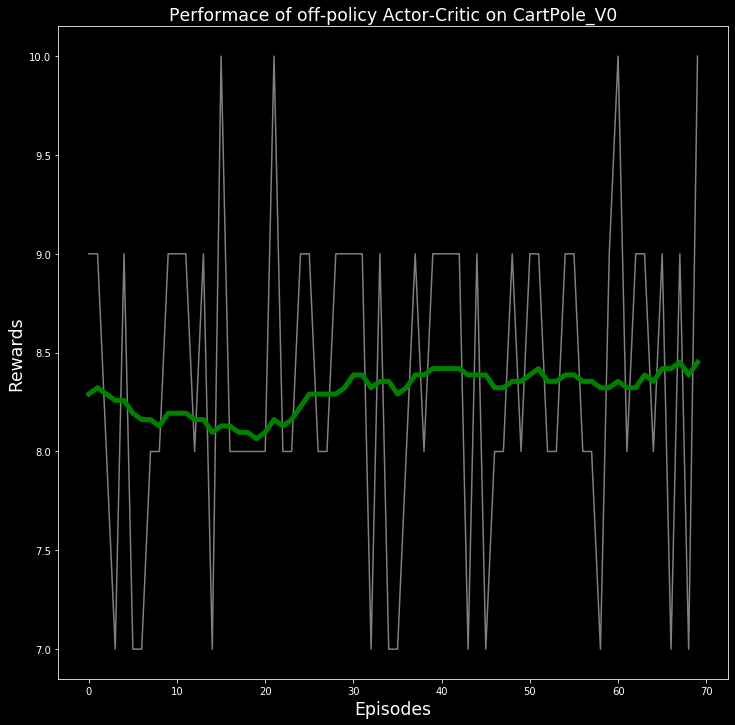

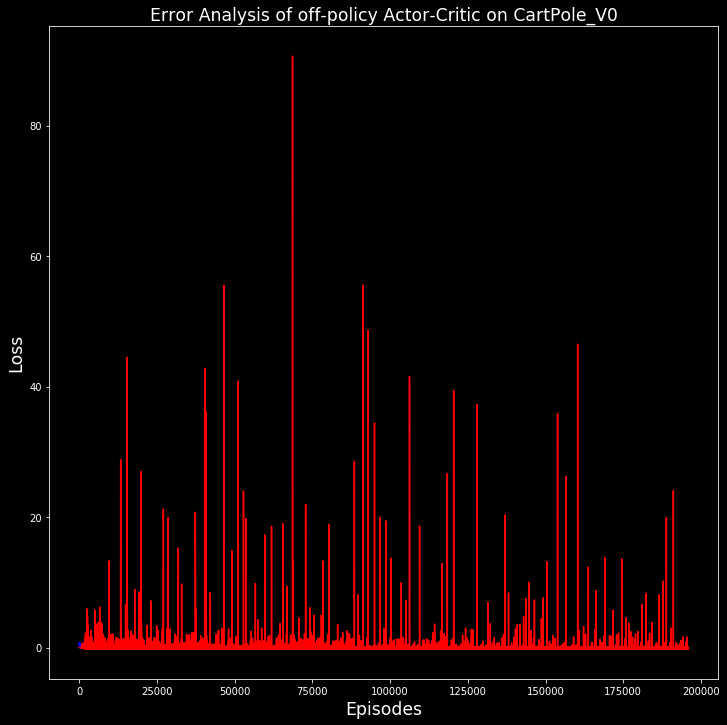

In [29]:
device = 'cpu'
# I do not recommend using GPU for this method. CPU is much faster.
# Change this to cuda only if you have a poor CPU or on a cloud
env = gym.make('CartPole-v0')
obs = env.reset()
gamma = 0.99
alpha_c = 0.01
actor = Actor()
optimizer_actor= torch.optim.Adam(actor.parameters(), lr=0.0004)
actor.to(device)
steps = []
for episode in range(2000):
    I = 1
    for step in range(200):
        #-----lines below are line-corresponding to the original algorithm----
        obs = np.reshape(obs, [1,-1])
        input_actor = Variable(torch.from_numpy(obs).float()).to(device)
        action_probability, _ = actor(input_actor)
        p = np.exp(action_probability[0].detach().cpu())
        if np.random.random()<0.1:
            action = np.random.randint(2)
        else:
            action = np.random.choice(2, p=p.numpy())
        log_prob = action_probability[0][action]
        buffer = [obs, action,I, p[action]]
        I *= gamma
        obs, reward, done, info = env.step(action)
        buffer.append(done)
        actor.buffer_in(buffer[0],buffer[1], buffer[2], buffer[3], buffer[4] )
        if done:
            steps.append(step)
            print(f'Training: episode {episode}, step {step}', end='\r')
            obs = env.reset()
            break
actor.evaluate()
mid = []
interval = 30
plt.style.use('dark_background')
for i in range(len(steps) - interval):
    mid.append(np.mean(steps[i:i+interval+1]))
plt.figure(figsize=(12,12))
plt.title('Training of off-policy Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Rewards',fontsize = 'xx-large')
x_fit = list(range(len(steps) - interval))
plt.plot(x_fit, steps[interval:], '-', c = 'gray', label='Reward') 
plt.plot(mid, '-', c= 'green', linewidth = 5, label='Moving Average Reward')
plt.show()
#----------
mid = []
interval = 30
plt.style.use('dark_background')
for i in range(len(actor.steps) - interval):
    mid.append(np.mean(actor.steps[i:i+interval+1]))
plt.figure(figsize=(12,12))
plt.title('Performace of off-policy Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Rewards',fontsize = 'xx-large')
x_fit = list(range(len(actor.steps) - interval))
plt.plot(x_fit, actor.steps[interval:], '-', c = 'gray', label='Reward') 
plt.plot(mid, '-', c= 'green', linewidth = 5, label='Moving Average Reward')
plt.show()
plt.figure(figsize=(12,12))
plt.title('Error Analysis of off-policy Actor-Critic on CartPole_V0',fontsize = 'xx-large')
plt.xlabel('Episodes', fontsize = 'xx-large')
plt.ylabel('Loss',fontsize = 'xx-large')
plt.plot(actor.A_Loss, c = 'blue', label = 'Actor_Loss')
plt.plot(actor.C_Loss, c = 'red', label = 'Critic_Loss')
plt.show()